##### RQ5: How does FairST perform with with different ML models? 
For all the previous RQs, the performance of FairST is examined with a Neural Network model. This RQ aims to evaluate the performance across a larger variety of ML models.

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from experiment_utils import *
from src import *


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


# SAVE TO RESULTS FILE

In [3]:
FOLDER = "RQ5_DIFF_MODELS"

if not os.path.exists(FOLDER):
    os.makedirs(FOLDER)

In [4]:
def f(df, reader): # Keep only K and KP
    df['TEMP'] = df['other'].apply(reader._get_losses_used)
    df = df[(~df["bias mitigation"].str.contains('FYP VAE')) | df["TEMP"].str.contains('Sensitive KL loss') ]
    df = df[~(df["TEMP"].str.contains("Flipped"))]
    df = df[~(df["TEMP"].str.contains("Latent"))]
    return df.drop(columns=['TEMP'])

### APPENDIX: all meatrics for all models KP, K and baselines

In [4]:
for attr in [["sex"],["race"],["race", "sex"]]:            
    files = [os.path.join("results","RESULTS_"+'_'.join(attr)+".csv")]
    
    reader = ResultsReader(files)    
    
    df = reader.get_mean_metrics()
    
    metric_order = ['f1score', 'MCC', '[SF] Statistical Parity Subgroup Fairness', '[DF] Differential Fairness']
    metric_order = ['f1score', '[SF] Statistical Parity Subgroup Fairness']
    group_cols = ['data','sensitive attrs', 'bias mitigation', 'other']
    df = df.pivot_table(index=group_cols, columns='ML method', values=metric_order)
    
    mean_df = df.groupby(group_cols).mean().reset_index()
        
    mean_df = mean_df.reindex(columns=sorted(mean_df.columns, key=lambda x: (x[1], metric_order.index(x[0]) if x[0] in metric_order else len(metric_order))))

    mean_df.to_csv(os.path.join(FOLDER,"MEAN_"+'_'.join(attr)+'.csv'), index=False)
    
    

File 'results\RESULTS_sex.csv' successfully loaded as DataFrame.
File 'results\RESULTS_race.csv' successfully loaded as DataFrame.
File 'results\RESULTS_race_sex.csv' successfully loaded as DataFrame.


### NR OF incr of SF BY MODEL

In [5]:
"""
For all baselines and my relavant losses count of times SF/F1 has been equal or higher than the 
baseline model, separately for each of the 6 ml models used
"""

for attr in [["sex"],["race"],["race", "sex"]]:
    files = [os.path.join("results","RESULTS_"+'_'.join(attr)+".csv")]
    reader = ResultsReader(files)
    reader.change_other_to_losses()

    rel_df = reader.get_relative_metrics()

    metrics_to_use = ["SF"]
    metrics_to_display = [m for m in reader.metrics if metric_has_substring(m,metrics_to_use )]
    metrics_to_display = ['[SF] Statistical Parity Subgroup Fairness']
    
    df = rel_df
        
    if df.shape[0] > 0: # in case some dataset has no results for some metrics
        counts_total = df[(df["bias mitigation"].str.contains('No'))].groupby(["bias mitigation", "other"]).count()[metrics_to_display]
        result = df.groupby(["data","bias mitigation", "other", "ML method"])[metrics_to_display].apply(lambda x: (x >= 0).sum()).reset_index()
        results = pd.concat([result, counts_total])
        
        for i, metric in enumerate(metrics_to_display):
            pivot_df = results.pivot_table(index=["data","bias mitigation", "other"], columns='ML method', values=metric, aggfunc='sum', fill_value=0)            
            pivot_df.to_csv(os.path.join(FOLDER,metrics_to_use[i]+'_PER_MODEL_nr_incr_'+"_".join(attr)+'.csv'), index=True,  index_label=["data","bias mitigation", "other"])

File 'results\RESULTS_sex.csv' successfully loaded as DataFrame.
File 'results\RESULTS_race.csv' successfully loaded as DataFrame.
File 'results\RESULTS_race_sex.csv' successfully loaded as DataFrame.


# VIS

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from experiment_utils import *
from src import *


In [6]:
size = 3

In [7]:
def f(df, reader, ml_method='nn'): # Keep only K and KP
    df = df[(df["ML method"].str.contains(ml_method))]
    df['TEMP'] = df['other'].apply(reader._get_losses_used)
    df = df[~(df["TEMP"].str.contains("Pos")) ]
    df = df[(~df["bias mitigation"].str.contains('FYP VAE'))  | df["TEMP"].str.contains('Sensitive KL loss') ]
    df = df[~(df["TEMP"].str.contains("Flipped"))]
    df = df[~(df["TEMP"].str.contains("Latent"))]
    return df.drop(columns=['TEMP'])

In [8]:
files, datasets, titles = get_all_single_attr_files(False)
files = files[:2]

In [9]:
models = [
    ["NN","nn keras"],
    ["SV","SupportVectorClassifier"],
    ["LR","LogisticRegression"],
    ["NB","NaiveBayes"],
    ["DT","DecisionTreeRegressor"],
    ["RF","RandomForestClassifier"],
]

In [10]:


sf_per_ml = []
f1_per_ml = []
lables = []
for j in range(6):
    colors = []
    lables = []
    model_short, model_name = models[j]
    reader = ResultsReader(files)
    fltr = lambda df, reader: f(df, reader, model_name)
    
    
    reader.df = fltr(reader.df, reader)
    reader.df[ResultsReader.ATTR] = ''
    reader.df[ResultsReader.DATASET] = ''
    reader.df[ResultsReader.OTHER] = ''
    
    m = reader.get_mean_metrics()
    m =  m.reindex([0,3,1,5,2,4])
    g = ResultsGrapher(reader)
    for index, row in m.iterrows():
        lables.append(g._row_label_generator(row))
    lables[0] = 'K'
    
    
    
    sf_per_ml.append([model_short] + list(m['[SF] Statistical Parity Subgroup Fairness']))
    f1_per_ml.append([model_short] + list(m['f1score']))   

legend = [g._get_legend_text("\{\}", l) for l in lables]
legend[0] = "FairST"
colors = [g.get_color(l) for l in lables]


File 'results/RESULTS_sex.csv' successfully loaded as DataFrame.
File 'results/RESULTS_race.csv' successfully loaded as DataFrame.
File 'results/RESULTS_sex.csv' successfully loaded as DataFrame.
File 'results/RESULTS_race.csv' successfully loaded as DataFrame.
File 'results/RESULTS_sex.csv' successfully loaded as DataFrame.
File 'results/RESULTS_race.csv' successfully loaded as DataFrame.
File 'results/RESULTS_sex.csv' successfully loaded as DataFrame.
File 'results/RESULTS_race.csv' successfully loaded as DataFrame.
File 'results/RESULTS_sex.csv' successfully loaded as DataFrame.
File 'results/RESULTS_race.csv' successfully loaded as DataFrame.
File 'results/RESULTS_sex.csv' successfully loaded as DataFrame.
File 'results/RESULTS_race.csv' successfully loaded as DataFrame.


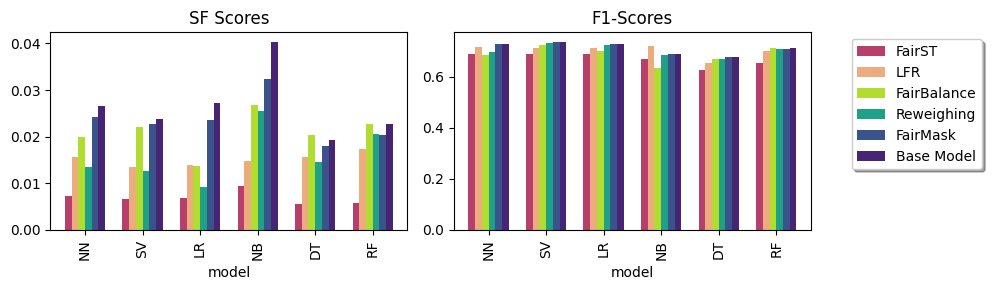

   model    FairST       LFR  FairBalance  Reweighing  FairMask  Base Model
0      0  0.007297  0.015733     0.019840    0.013508  0.024192    0.026511
1      0  0.006626  0.013490     0.022155    0.012565  0.022789    0.023841
2      0  0.006825  0.013993     0.013740    0.009300  0.023597    0.027140
3      0  0.009332  0.014852     0.026809    0.025580  0.032431    0.040351
4      0  0.005610  0.015748     0.020459    0.014577  0.017905    0.019270
5      0  0.005830  0.017347     0.022805    0.020662  0.020440    0.022647
model          0.000000
FairST         0.006920
LFR            0.015194
FairBalance    0.020968
Reweighing     0.016032
FairMask       0.023559
Base Model     0.026627
dtype: float64
   model    FairST       LFR  FairBalance  Reweighing  FairMask  Base Model
0      0  0.688317  0.717057     0.686347    0.694816  0.727137    0.728809
1      0  0.688375  0.712909     0.725162    0.730787  0.736071    0.736770
2      0  0.688715  0.713154     0.700261    0.723323  0.

In [11]:
df_sf = pd.DataFrame(sf_per_ml, columns=['model']+legend) 
df_f1 = pd.DataFrame(f1_per_ml, columns=['model']+legend) 

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

df_sf.plot(ax=axes[0], x='model', color=colors, kind='bar', stacked=False, title='SF Scores', width=0.7)
df_f1.plot(ax=axes[1], x='model', color=colors, kind='bar', stacked=False, title='F1-Scores', width=0.7)


axes[0].get_legend().remove()

axes[1].legend(loc='upper right', bbox_to_anchor=(1.5, 1), ncol=1, fancybox=True, shadow=True)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('imgs/RQ5_bar.png', bbox_inches='tight')
plt.show()

df_sf['model'] = 0
print(df_sf)
print(df_sf.mean(skipna=True))

df_f1['model'] = 0
print(df_f1)
print(df_f1.mean(skipna=True))



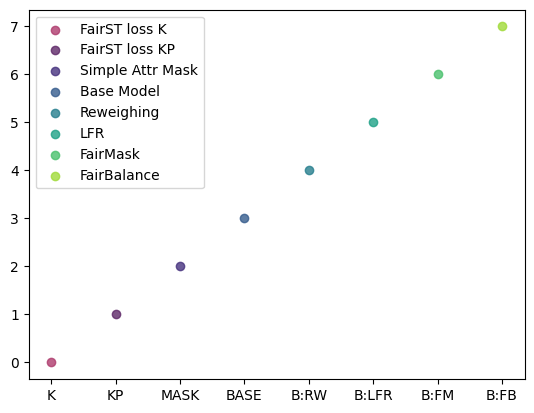

In [38]:
# LEGEND!
grapher = ResultsGrapher(None)
labels  = ["K","KP","MASK",'BASE',"B:RW","B:LFR","B:FM","B:FB"]
for i, l in enumerate(labels):
    plt.scatter(
            l,
            i,
            label=grapher._get_legend_text(l, l),
            color=grapher.get_color(l),
            alpha=0.8,
        )
plt.legend()
plt.show()

In [12]:
def f(df, reader, ml_method='nn'): # Keep only K and KP
    df = df[(df["ML method"].str.contains(ml_method))]
    df['TEMP'] = df['other'].apply(reader._get_losses_used)
    df = df[~(df["TEMP"].str.contains("Recon")) | df["TEMP"].str.contains('Sensitive KL loss') ]
    df = df[~(df["TEMP"].str.contains("Pos")) ]
    df = df[~(df["TEMP"].str.contains("Flipped"))]
    df = df[~(df["TEMP"].str.contains("Latent"))]
    return df.drop(columns=['TEMP'])

File 'results\RESULTS_with_no_vae_sex.csv' successfully loaded as DataFrame.
metrics to display: [SF] Statistical Parity Subgroup Fairness f1score  | all found  ['sex|[SF] Statistical Parity Subgroup Fairness for One Attribute', '[SF] Statistical Parity Subgroup Fairness'] ['f1score']
File 'results\RESULTS_with_no_vae_race.csv' successfully loaded as DataFrame.
metrics to display: [SF] Statistical Parity Subgroup Fairness f1score  | all found  ['race|[SF] Statistical Parity Subgroup Fairness for One Attribute', '[SF] Statistical Parity Subgroup Fairness'] ['f1score']
File 'results\RESULTS_with_no_vae_sex.csv' successfully loaded as DataFrame.
metrics to display: [SF] Statistical Parity Subgroup Fairness f1score  | all found  ['sex|[SF] Statistical Parity Subgroup Fairness for One Attribute', '[SF] Statistical Parity Subgroup Fairness'] ['f1score']
File 'results\RESULTS_with_no_vae_race.csv' successfully loaded as DataFrame.
metrics to display: [SF] Statistical Parity Subgroup Fairness 

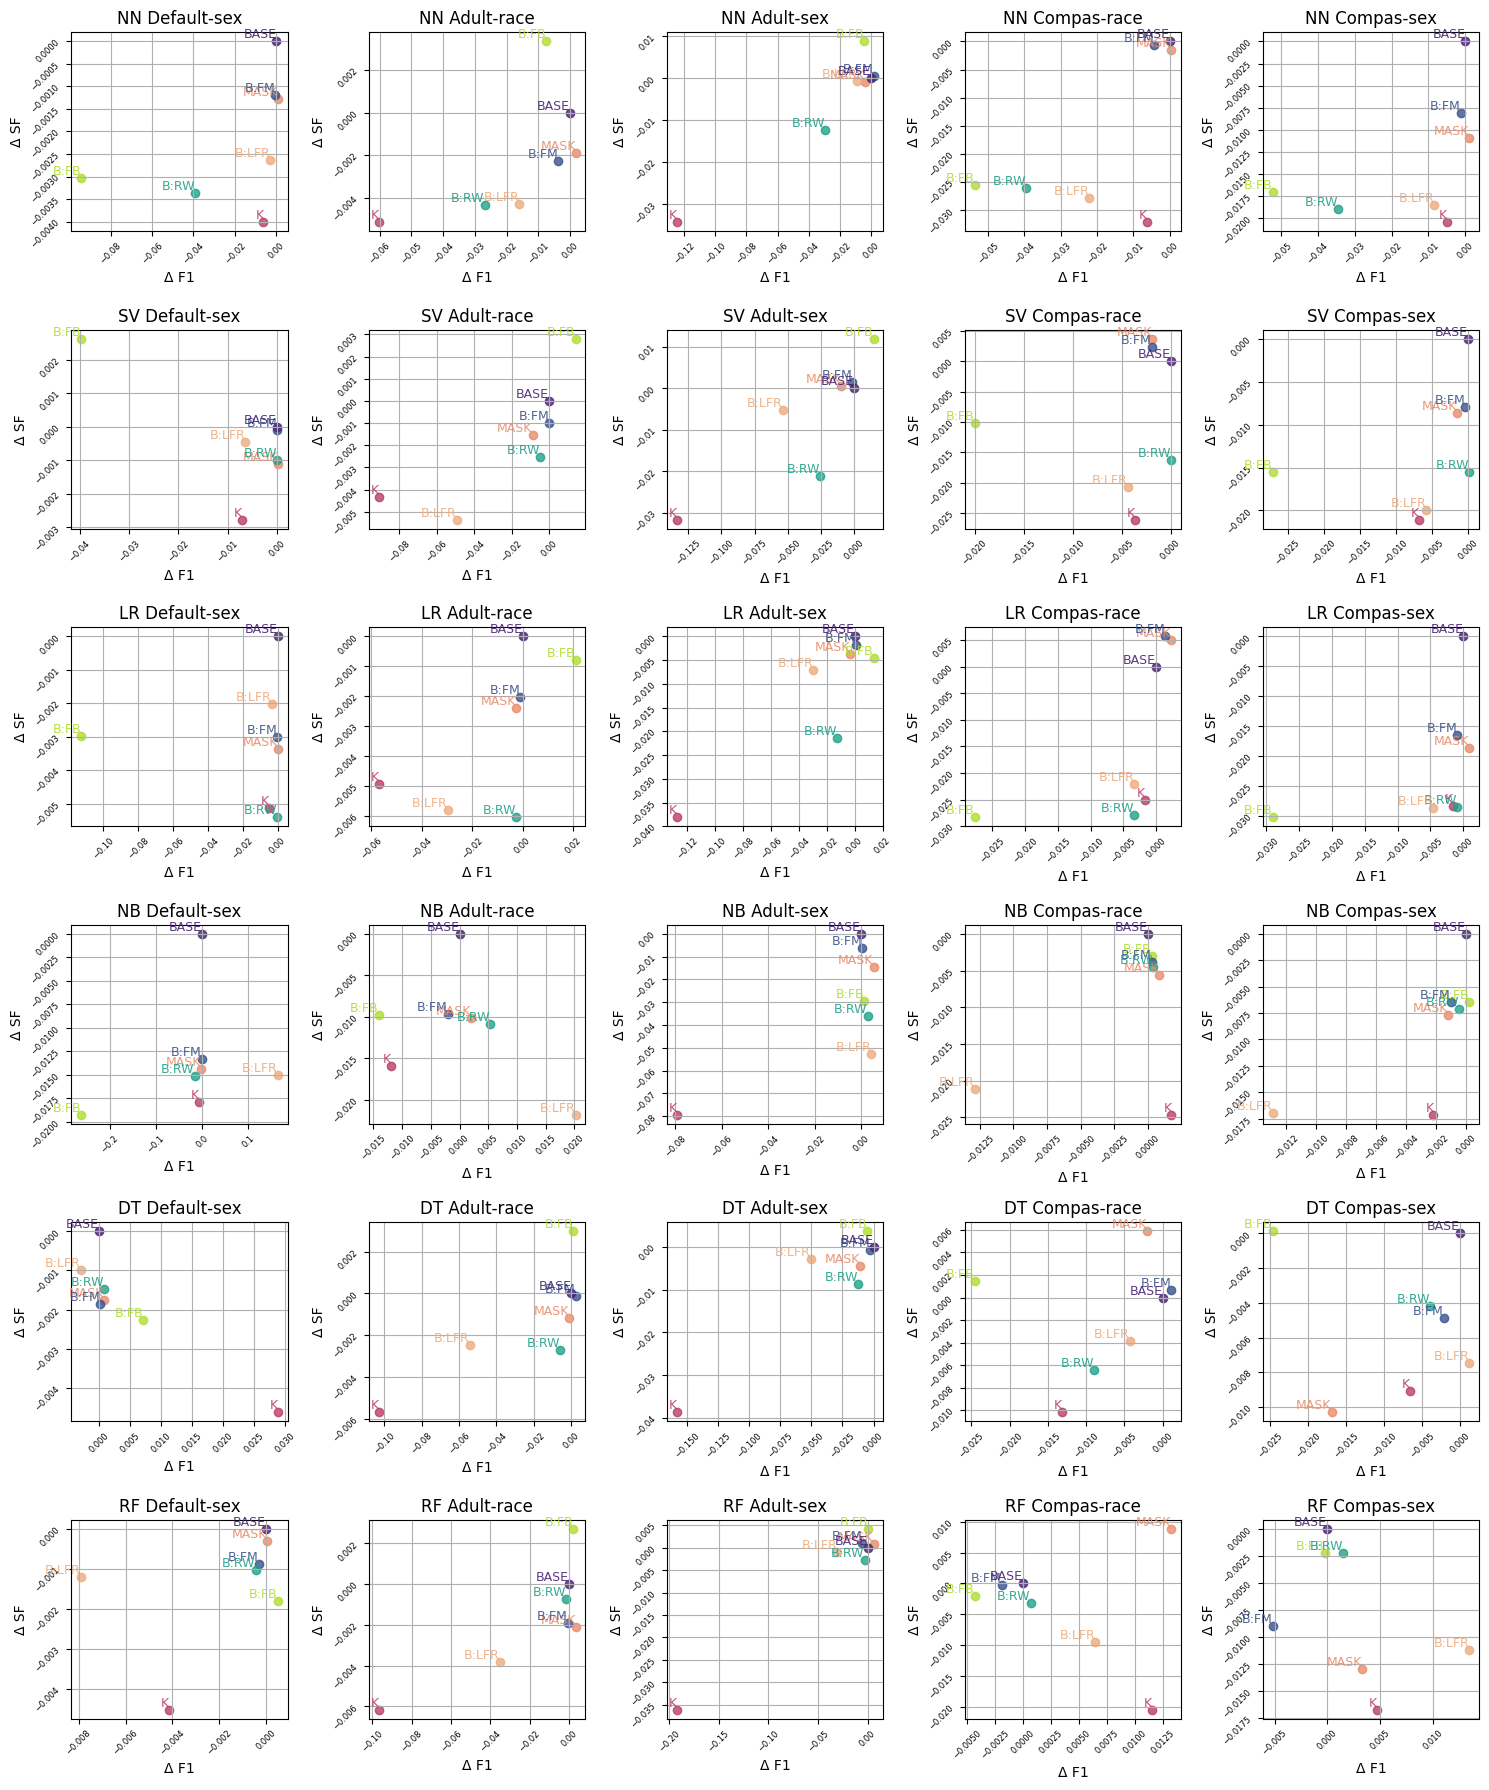

In [13]:

F, axes = plt.subplots(6, 5, figsize=(size*(5), size*6))
for j in range(6):
    model_short, model_name = models[j]
    fltr = lambda df, reader: f(df, reader, model_name)
    for i in range(5):
        plot_one_run(fltr, files[i], datasets[i], axes[j][i], y_metric='SF')
        axes[j][i].set_title(model_short+' '+titles[i])
        axes[j][i].set_ylabel("Δ SF") # comment out to make sure 
        axes[j][i].set_xlabel("Δ F1")
        
plt.rc('axes', axisbelow=True)
plt.tight_layout()
plt.savefig('imgs/RQ5_all_models_F1_DF.png')
plt.show()
